In [1]:
import importlib
import numpy as np
import scipy as sp
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math as mth
from tensorflow.python.framework import ops
from IPython.display import clear_output
from scipy.interpolate import interp1d
import os,shutil
import pandas as pd
from tensorflow.python.client import timeline


In [37]:
import CBI
import population
importlib.reload(CBI)
importlib.reload(population)

<module 'population' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/population.py'>

###  Create a subject

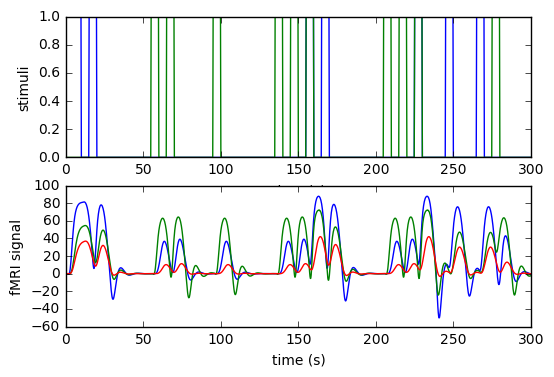

In [54]:
s=population.get_a_subject()
m=CBI.configure_a_scanner(t_delta=0.25,n_stimuli=2)
u,y,x,h=m.quick_scan(s,return_x=True,return_h=True)
# tmp=s.show_all_variable_value(True)
plt.subplot(211)
plt.plot(np.arange(m.n_time_point)*m.t_delta,u.transpose())
plt.xlabel('time (s)')
plt.ylabel('stimuli')
plt.subplot(212)
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

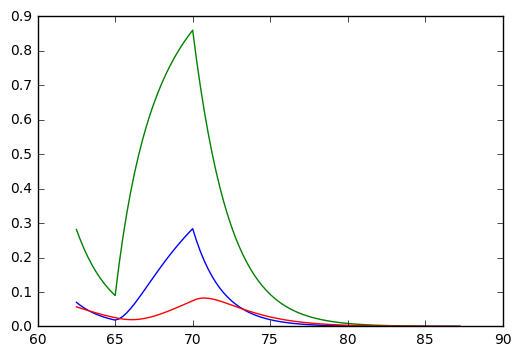

In [55]:
plt.plot(np.arange(250,350)*m.t_delta,x[:,0,250:350].transpose())


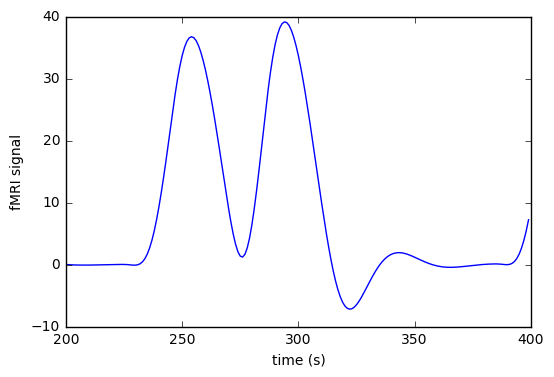

In [56]:
#plt.plot(np.arange(m.n_time_point),y[0,:,:].transpose())
plt.plot(np.arange(200,400),y[0,:,200:400].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')


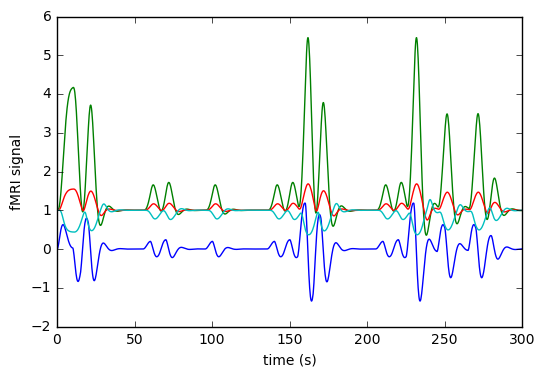

In [57]:
plt.plot(np.arange(m.n_time_point)*m.t_delta,h[0,:,:].transpose())
#plt.plot(np.arange(250,350),h[0,:,250:350].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

In [32]:
from colorama import Fore, Style
print(Fore.RED + 'some red text')
print(Back.GREEN + 'and with a green background')
print(Style.DIM + 'and in dim text')
print(Style.RESET_ALL)
print('back to normal now')
print('test')

some red text


NameError: name 'Back' is not defined

In [519]:
print(Fore.RED + 'some red text')
print('test')
print(Style.RESET_ALL)
print('back to normal now')
print('test')

some red text
test

back to normal now
test


In [520]:
print('\033[31m' + 'some red text')
print('\033[30m') # and reset to default color
print('test')

some red text

test


In [510]:
print('test')
print(Fore.RED + 'Warning:')
print(Style.RESET_ALL)
print('test')
print('test')
print(Style.RESET_ALL)
print('test')

test

test
test

test


### Evaluate downsampling and interplation effect

In [490]:
# downsample fMRI signal
factor_downsample=mth.floor(2/m.t_delta)
t_axis_downsampled=np.arange(0,m.n_time_point,factor_downsample)
y_down_sampled=[y[n,:,0:m.n_time_point+1:factor_downsample] for n in range(m.n_region)]
y_down_sampled=np.asarray(y_down_sampled)

In [474]:
# fit interplate function
interplate_function_list=[]
for n in range(m.n_region):
    f =  interp1d(t_axis_downsampled, y_down_sampled[n,0,:], kind='cubic')
    interplate_function_list.append(f)

fine scale temporal interval = 0.25 s
down sampled to temporal interval = 2 s
full fMRI signal length = (1200,)
down sampled fMRI signal length = (150,)


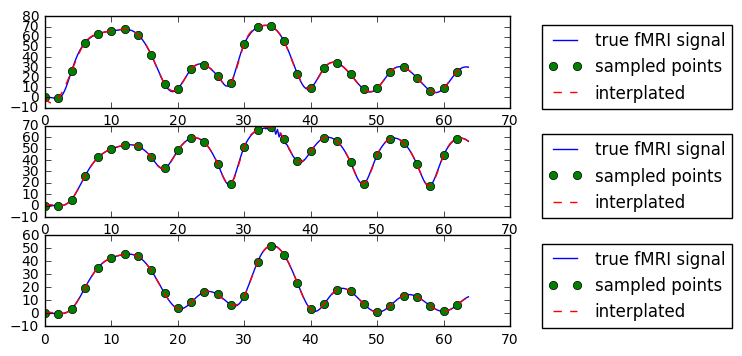

In [475]:
# visulize interplation results
n_vis=256
n_vis_downsampled=int(n_vis/factor_downsample)
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(0,n_vis)*m.t_delta,s.f_output[n,0,:n_vis],label="true fMRI signal")
    plt.plot(t_axis_downsampled[:n_vis_downsampled]*m.t_delta,y_down_sampled[n,0,:n_vis_downsampled].transpose(),'go',label="sampled points")
    plt.plot(np.arange(0,n_vis)*m.t_delta,interplate_function_list[n](np.arange(0,n_vis)),'r--',label="interplated")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
print('fine scale temporal interval = '+str(m.t_delta)+' s')
print('down sampled to temporal interval = 2 s')
print('full fMRI signal length = '+str(s.f_output[n,0,:].shape))
print('down sampled fMRI signal length = '+str(s.f_output[n,0,::int(2/m.t_delta)].shape))

### Data preparation

In [39]:
import data_helper
importlib.reload(data_helper)

<module 'data_helper' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/data_helper.py'>

In [40]:
# target u: [m.n_stimuli, n_recurrent_step]
# target x: [m.n_region, n_recurrent_step]
n_recurrent_step=12

dh=data_helper.get_a_data_helper()
dh.u=u[:]
dh.x=x[:]
dh.y=y[:]

dh.u_list=dh.cut2shape(dh.u,[m.n_stimuli, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.x_list=dh.cut2shape(dh.x,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_list=dh.cut2shape(dh.y,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
print('u_list has '+str(len(dh.u_list))+' segments, each of size '+str(dh.u_list[0].shape))
print('x_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))
print('y_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))

u_list has 100 segments, each of size (1, 12)
x_list has 100 segments, each of size (3, 12)
y_list has 100 segments, each of size (3, 12)


### Inference, start from u->x

In [75]:
# build DCM-RNN
ops.reset_default_graph()
import DCM_RNN
importlib.reload(DCM_RNN)
dr=DCM_RNN.create_a_dcm_rnn(m,n_recurrent_step=n_recurrent_step,learning_rate=0.01)
util=DCM_RNN.utilities()

In [76]:
# training summary
acc_Wxx=1-util.rMSE(dr.Wxx,s.Wxx)
acc_Wxxu=1-util.rMSE(dr.Wxxu,s.Wxxu)
acc_Wxu=1-util.rMSE(dr.Wxu,s.Wxu.reshape((m.n_region,1)))

loss_summary = tf.scalar_summary('fMRI_prediction_loss',dr.total_loss_y)
acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
opt_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])

summary_dir = os.path.abspath(os.path.join(os.path.curdir, "summary"))

# remove existing files
for the_file in os.listdir(summary_dir):
    file_path = os.path.join(summary_dir, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [77]:
# time tracking
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

In [78]:
# open session and initilize
try:
    isess
except:
    isess = tf.InteractiveSession()
else:
    isess.close()
    isess = tf.InteractiveSession()

opt_init_all=tf.initialize_all_variables()
isess.run(opt_init_all)
# initilize matrices
#isess.run(dr.Wxx.assign(dr.Wxx_init))
#isess.run(dr.Wxxu.assign(dr.Wxxu_init))
#isess.run(dr.Wxu.assign(dr.Wxu_init))
# add summary
summary_writer = tf.train.SummaryWriter(summary_dir, isess.graph)

In [ ]:
# check forward pass, use the "true" parameters
Wxx=np.array([[-0.65,-0.2,0],[0.4,-0.4,-0.3],[0,0.2,-0.3]])*m.t_delta+np.eye(m.n_region,m.n_region,0)
Wxxu=np.array([[0.5,0,0.25],[0,0,0],[0,0,0.3]])*m.t_delta
Wxu=np.array([0.5,0,0]).reshape(3,1)*m.t_delta
# update matrices
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [79]:
tmp=util.show_all_variable_value(dr,isess,visFlag=True)

Wxx


,From_r0,From_r1,From_r2
To_r0,0.875,0.000,0.000
To_r1,0.000,0.875,0.000
To_r2,0.000,0.000,0.875


Wxxu


,From_r0,From_r1,From_r2
To_r0,0.0,0.0,0.0
To_r1,0.0,0.0,0.0
To_r2,0.0,0.0,0.0


Wxu


,stimuli_0
To_r0,0.125
To_r1,0.000
To_r2,0.000


hemodynamic_parameters


,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999
region_1,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999
region_2,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999


In [80]:
# run forward pass
x_predicted=util.forward_pass_x(dr,dh,isess)
h_predicted=util.forward_pass_h(dr,dh,isess)
y_predicted=util.forward_pass_y(dr,dh,isess)

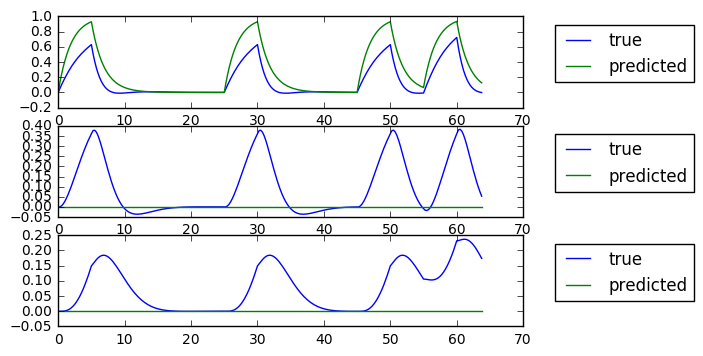

In [81]:
# visulize pridicted x_state and true x_state (before training)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

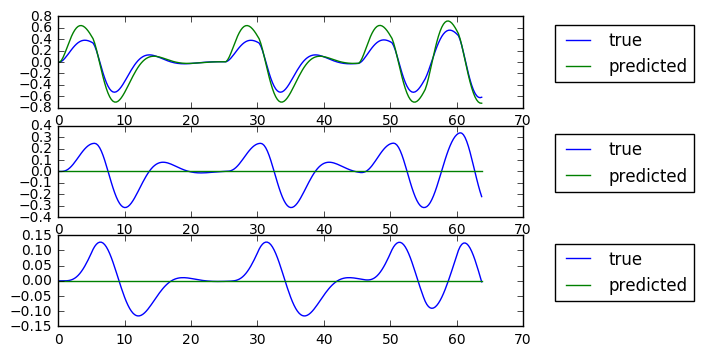

In [82]:
# visulize pridicted h_state and true h_state (before training)
n_monitor=256
i_h_state=0
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

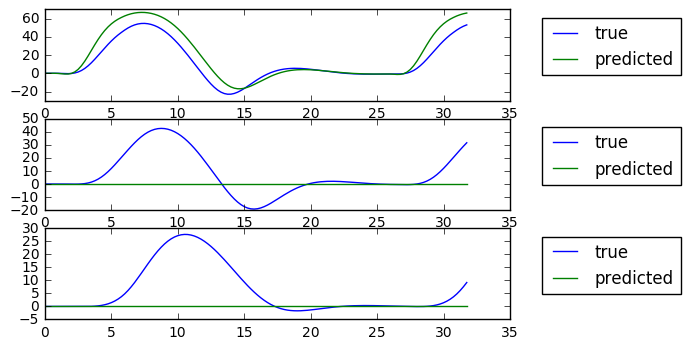

In [83]:
# y_predicted=util.forward_pass_y(dr,dh,isess)
# visulize pridicted y_predicted and true y 
n_monitor=128
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [90]:
# training
# f=open('timeline.json', 'w')
n_epoch=16
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0.
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    x_feed[0]=0.00001
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    h_feed[0][0]+=0.00001
    for i in range(0,len(dh.u_list)):
    #for i in range(0,1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        
        grads_and_vars_tmp, tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                                    feed_dict=feed_dict)
                                                    #options=run_options, run_metadata=run_metadata)
        loss_sum+=loss_tmp 
        #tl = timeline.Timeline(run_metadata.step_stats)
        #ctf = tl.generate_chrome_trace_format()
    #f.write(ctf)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))

    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss 1606.86, acc_Wxx 0.931131, acc_Wxxu 0.0539172, acc_Wxu 0.631522
epoch 1, loss 1555.48, acc_Wxx 0.932083, acc_Wxxu 0.0568885, acc_Wxu 0.627882
epoch 2, loss 1506.68, acc_Wxx 0.932962, acc_Wxxu 0.0598571, acc_Wxu 0.624706
epoch 3, loss 1461.06, acc_Wxx 0.933759, acc_Wxxu 0.0628259, acc_Wxu 0.621973
epoch 4, loss 1419.72, acc_Wxx 0.93446, acc_Wxxu 0.065792, acc_Wxu 0.619631
epoch 5, loss 1384.58, acc_Wxx 0.935057, acc_Wxxu 0.0687406, acc_Wxu 0.617581
epoch 6, loss 1358.66, acc_Wxx 0.935542, acc_Wxxu 0.0716347, acc_Wxu 0.615662
epoch 7, loss 1346.75, acc_Wxx 0.935908, acc_Wxxu 0.0743936, acc_Wxu 0.613611
epoch 8, loss 1356.6, acc_Wxx 0.936154, acc_Wxxu 0.0768482, acc_Wxu 0.610988
epoch 9, loss 1401.67, acc_Wxx 0.936286, acc_Wxxu 0.0786332, acc_Wxu 0.607022
epoch 10, loss 1507.83, acc_Wxx 0.93632, acc_Wxxu 0.0788978, acc_Wxu 0.600251
epoch 11, loss 1734.79, acc_Wxx 0.936298, acc_Wxxu 0.075342, acc_Wxu 0.587511
epoch 12, loss 2270.49, acc_Wxx 0.936292, acc_Wxxu 0.0598586, acc_W

KeyboardInterrupt: 

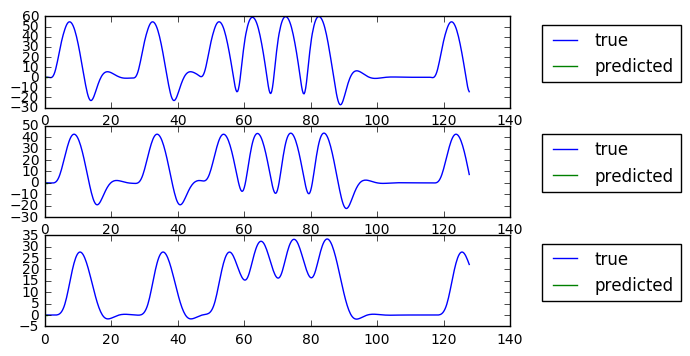

In [91]:
y_predicted=util.forward_pass_y(dr,dh,isess)
n_monitor=512
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [92]:
tmp=util.show_all_variable_value(dr,isess,visFlag=True)

Wxx


,From_r0,From_r1,From_r2
To_r0,NaN,NaN,NaN
To_r1,NaN,NaN,NaN
To_r2,NaN,NaN,NaN


Wxxu


,From_r0,From_r1,From_r2
To_r0,NaN,NaN,NaN
To_r1,NaN,NaN,NaN
To_r2,NaN,NaN,NaN


Wxu


,stimuli_0
To_r0,NaN
To_r1,NaN
To_r2,NaN


hemodynamic_parameters


,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999
region_1,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999
region_2,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999


In [86]:
print(s.Wxx)
print(s.Wxxu)
print(s.Wxu)

[[ 0.74000001 -0.08000001  0.        ]
 [ 0.16000001  0.83999997 -0.12      ]
 [ 0.          0.08000001  0.88      ]]
[[ 0.2   0.    0.1 ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.12]]
[ 0.08000001  0.          0.        ]


In [87]:
# run forward pass
x_predicted=util.forward_pass_x(dr,dh,isess)
h_predicted=util.forward_pass_h(dr,dh,isess)
y_predicted=util.forward_pass_y(dr,dh,isess)

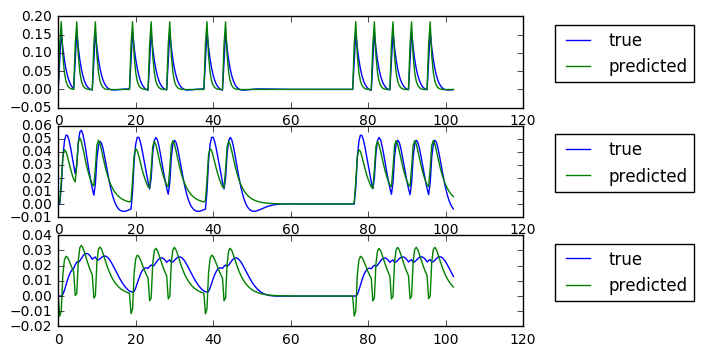

In [88]:
# visulize pridicted x_state and true x_state (before training)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

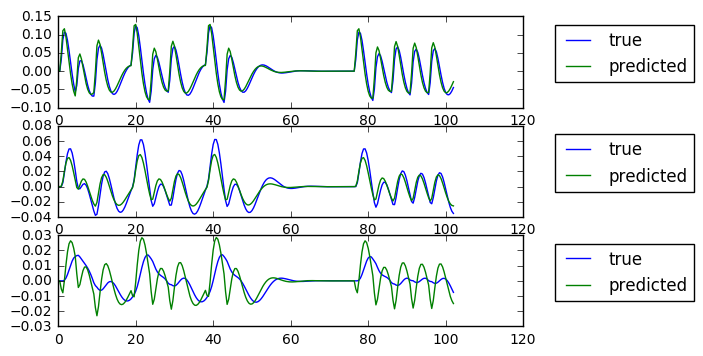

In [89]:
# visulize pridicted h_state and true h_state (before training)
n_monitor=256
i_h_state=0
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

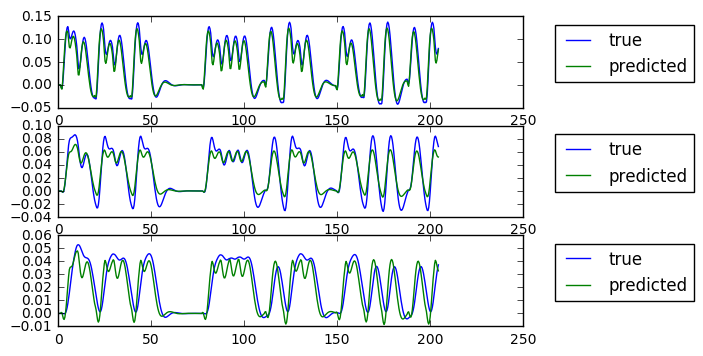

In [90]:
# y_predicted=util.forward_pass_y(dr,dh,isess)
# visulize pridicted y_predicted and true y 
n_monitor=512
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [53]:
# save the results
import pickle  
variable_dict={}
variable_dict['Wxx_init']=np.array([[-0.5,-0,0],[0,-0.5,0],[0,0,-0.5]],dtype=np.float32)*m.t_delta+np.eye(m.n_region,m.n_region,0,dtype=np.float32)
variable_dict['Wxxu_init']=np.array([[0,0,0],[0,0,0],[0,0,0]],dtype=np.float32)*m.t_delta
variable_dict['Wxu_init']=np.array([0.5,0,0],dtype=np.float32).reshape(3,1)*m.t_delta

variable_dict['Wxx_true']=np.array([[-0.65,-0.2,0],[0.4,-0.4,-0.3],[0,0.2,-0.3]])*m.t_delta+np.eye(m.n_region,m.n_region,0)
variable_dict['Wxxu_true']=np.array([[0.5,0,0.25],[0,0,0],[0,0,0.3]])*m.t_delta
variable_dict['Wxu_true']=np.array([0.2,0,0]).reshape(3,1)*m.t_delta

variable_dict['Wxx_trained']=dr.Wxx.eval()
variable_dict['Wxxu_trained']=dr.Wxxu.eval()
variable_dict['Wxu_trained']=dr.Wxu.eval()

filehandler = open('/Users/yuanwang/Google_Drive/researchNote/regular_meeting/data20161020', 'wb')  
pickle.dump(variable_dict, filehandler)
filehandler.close()

In [421]:
# used to check loss definition, result: it seems correct
n_epoch=1
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0.
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    #x_feed[0]=0.00000001
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    for i in range(0,len(dh.u_list)):
    #for i in range(0,1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        
        tmp_x,tmp_y,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([\
                                                    dr.x_state_predicted,
                                                    dr.y_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                                    feed_dict=feed_dict)
        loss_sum+=loss_tmp
    #print('epoch = '+str(epoch))

In [323]:
# training
n_epoch=8
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0.
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    x_feed[0]=0.000000001
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    h_feed[0][0]+=0.000000001
    for i in range(0,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        
        grads_and_vars_tmp, tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                                    feed_dict=feed_dict)
        loss_sum+=loss_tmp 
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))

    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss 2.22785, acc_Wxx 0.892343, acc_Wxxu 0.0635171, acc_Wxu -0.645476
epoch 1, loss 2.27464, acc_Wxx 0.892109, acc_Wxxu 0.063457, acc_Wxu -0.650505
epoch 2, loss 2.32412, acc_Wxx 0.891866, acc_Wxxu 0.0633923, acc_Wxu -0.655595
epoch 3, loss 2.37659, acc_Wxx 0.891614, acc_Wxxu 0.0633224, acc_Wxu -0.660749
epoch 4, loss 2.43233, acc_Wxx 0.891352, acc_Wxxu 0.0632468, acc_Wxu -0.665971
epoch 5, loss 2.49171, acc_Wxx 0.89108, acc_Wxxu 0.0631652, acc_Wxu -0.671266
epoch 6, loss 2.55517, acc_Wxx 0.890796, acc_Wxxu 0.0630767, acc_Wxu -0.676641
epoch 7, loss 2.62318, acc_Wxx 0.890499, acc_Wxxu 0.0629808, acc_Wxu -0.682101


In [332]:
tmp=util.show_all_variable_value(dr,isess,visFlag=True)

Wxx


,From_r0,From_r1,From_r2
To_r0,0.8375,-0.05,0.000
To_r1,0.1000,0.90,-0.075
To_r2,0.0000,0.05,0.925


Wxxu


,From_r0,From_r1,From_r2
To_r0,0.125,0.0,0.0625
To_r1,0.000,0.0,0.0000
To_r2,0.000,0.0,0.0750


Wxu


,stimuli_0
To_r0,0.125
To_r1,0.000
To_r2,0.000


hemodynamic_parameters


,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.32,0.34,0.65,0.41,0.98,0.4,1.0,0.03,25.0,40.299999
region_1,0.32,0.34,0.65,0.41,0.98,0.4,1.0,0.03,25.0,40.299999
region_2,0.32,0.34,0.65,0.41,0.98,0.4,1.0,0.03,25.0,40.299999


In [418]:
# used to check loss definition
n_epoch=1
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0.
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    for i in range(0,len(dh.u_list)):
    #for i in range(0,1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        x_feed,h_feed,loss_tmp\
                                                    = isess.run([\
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y],\
                                                    feed_dict=feed_dict)
        loss_sum+=loss_tmp
    #print('epoch = '+str(epoch))
print(loss_sum)
y_predicted=util.forward_pass_y(dr,dh,isess)
print(util.MSE_loss_np(y,y_predicted)*m.n_time_point/n_recurrent_step)


0.80746870623
0.807468700101


In [413]:
# used to check loss, segment by segment
n_epoch=1
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0.
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    for i in range(0,64):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        y_tmp,x_feed,h_feed,loss_tmp\
                                                    = isess.run([\
                                                    dr.y_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y],\
                                                    feed_dict=feed_dict)
        loss_sum+=loss_tmp
    #print('epoch = '+str(epoch))
print('in_built_loss')
print(loss_tmp)
print('in_built_prediction')
print(util.MSE_loss_np(np.asarray(y_tmp)[:,:,0].transpose(),np.asarray(dh.y_list[i])))
print('out_prediction')
#y_predicted=util.forward_pass_y(dr,dh,isess)
print(util.MSE_loss_np(y_predicted[:,i*8:(i+1)*8],np.asarray(dh.y_list[i])))

in_built_loss
0.00558686
in_built_prediction
0.00558686319534
out_prediction
0.00558686319534


In [359]:
# run forward pass
x_predicted=util.forward_pass_x(dr,dh,isess)
h_predicted=util.forward_pass_h(dr,dh,isess)
y_predicted=util.forward_pass_y(dr,dh,isess)

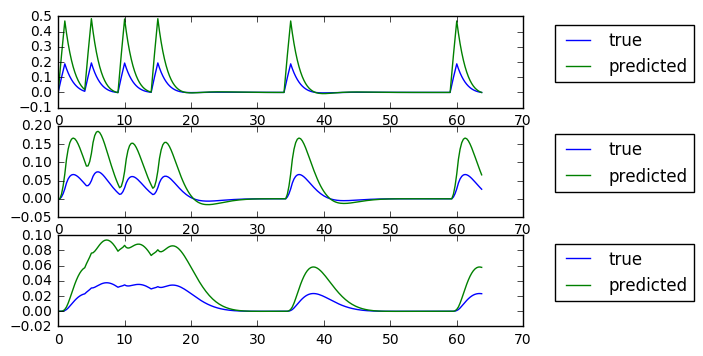

In [334]:
# visulize pridicted x_state and true x_state (before training)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

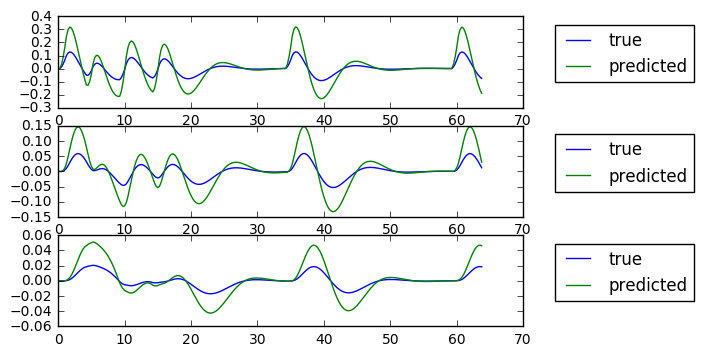

In [335]:
# visulize pridicted h_state and true h_state (before training)
n_monitor=256
i_h_state=0
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

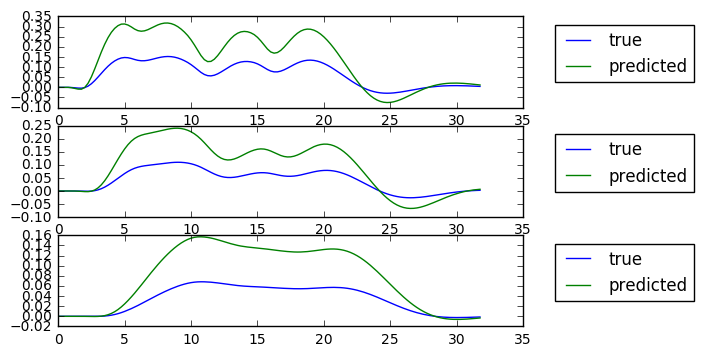

In [336]:
# y_predicted=util.forward_pass_y(dr,dh,isess)
# visulize pridicted y_predicted and true y 
n_monitor=128
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [337]:
util.MSE_loss_np(y,y_predicted)

0.0050466793756289577

In [789]:
# run training by minimizing y error
n_epoch=256
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0
    gradient_list=[]
    x_feed=np.zeros((m.n_region,1))
    x_feed[0]=0.0000001
    h_feed=[np.array([0,1,1,1],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    for i in range(0,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.rnn_x]=dh.x_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        
        
        _, tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                                    feed_dict=feed_dict)
                                                
     
    #print(summaries)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))


    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    '''
    print('%%%%%%%%%%%%%% '+ str(epoch)+" %%%%%%%%%%%%")
    print("loss "+ "{:.6f}".format(loss_sum))
    print('rMSE')
    print(np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx))
    '''
    

epoch 0, loss 0, acc_Wxx nan, acc_Wxxu nan, acc_Wxu nan


KeyboardInterrupt: 

In [801]:
variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='rnn_cell')

dr.Wxx.eval()

array([[ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan]], dtype=float32)

In [730]:
# run training 
n_epoch=256
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0
    gradient_list=[]
    training_state=np.zeros((m.n_region,1))
    training_state[0]=0.0000001
    for i in range(0,len(dh.u_list)):

        _, tmp,training_state,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([dr.train_step,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.total_loss,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],\
                                       feed_dict={dr.rnn_u:dh.u_list[i], \
                                                  dr.rnn_x:dh.x_list[i],\
                                                  dr.x_state_initial:training_state})
     
    #print(summaries)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))


    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    '''
    print('%%%%%%%%%%%%%% '+ str(epoch)+" %%%%%%%%%%%%")
    print("loss i"+ "{:.6f}".format(loss_sum))
    print('rMSE')
    print(np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx))
    '''
    

AttributeError: 'create_a_dcm_rnn' object has no attribute 'train_step'

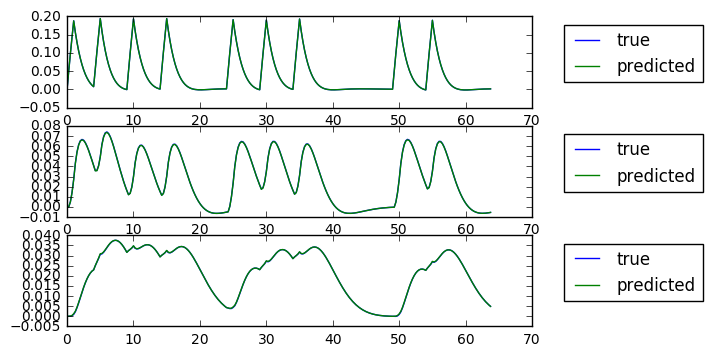

In [436]:
# show prediction accuracy after training
x_predicted=util.forward_pass(dr,dh,isess)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [437]:
print(dr.Wxx.eval())
print(s.Wxx)

[[  8.37508738e-01  -4.99544814e-02   4.28412459e-05]
 [  9.98858660e-02   8.99913967e-01  -7.50174373e-02]
 [  5.24617753e-05   5.00212200e-02   9.24988508e-01]]
[[ 0.8375 -0.05    0.    ]
 [ 0.1     0.9    -0.075 ]
 [ 0.      0.05    0.925 ]]


In [438]:
print(dr.Wxxu.eval())
print(s.Wxxu)

[[  1.24835826e-01  -1.18896656e-03   6.38780296e-02]
 [ -1.61269272e-04   6.87352076e-05   9.57742959e-05]
 [  1.59951509e-04   8.56118917e-04   7.38826916e-02]]
[[ 0.125   0.      0.0625]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.075 ]]


In [439]:
print(dr.Wxu.eval())
print(s.Wxu)

[[  4.99444790e-02]
 [ -6.62461971e-05]
 [  6.20318315e-05]]
[ 0.05  0.    0.  ]


##### backup sections

In [ ]:
# run training (backup)
n_epoch=128
for epoch in range(n_epoch):
    x_tmp=[]
    loss_sum=0
    gradient_list=[]
    training_state=np.zeros((m.n_region,1))
    training_state[0]=0.0000001
    for i in range(0,len(dh.u_list)):

        _, tmp,training_state,loss_tmp = isess.run([dr.train_step, dr.x_state_predicted,dr.x_state_final,dr.total_loss],\
                                       feed_dict={dr.rnn_u:dh.u_list[i], \
                                                  dr.rnn_x:dh.x_list[i],\
                                                  dr.x_state_initial:training_state})
        tmp=np.asarray(tmp)
        tmp=tmp[:,:,0]
        x_tmp.append(tmp)
        loss_sum+=loss_tmp
        
    dWxx=dr.Wxx.eval()-s.Wxx
    acc_Wxx=1-np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx)
    dWxxu=dr.Wxxu.eval()-s.Wxxu
    acc_Wxxu=1-np.linalg.norm(dWxxu)/np.linalg.norm(s.Wxxu)
    dWxu=dr.Wxu.eval()-s.Wxu.reshape(m.n_region,1)
    acc_Wxu=1-np.linalg.norm(dWxu)/np.linalg.norm(s.Wxu)
    
    # training summary
    loss_summary = tf.scalar_summary('loss',loss_sum)
    acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
    acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
    acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
    train_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])
    
    summary_writer.add_summary(all_summaries, step)




    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
          .format(epoch, loss_sum, acc_Wxx, acc_Wxxu, acc_Wxu))
    '''
    print('%%%%%%%%%%%%%% '+ str(epoch)+" %%%%%%%%%%%%")
    print("loss "+ "{:.6f}".format(loss_sum))
    print('rMSE')
    print(np.linalg.norm(dWxx)/np.linalg.norm(s.Wxx))
    '''
    

In [20]:
i=0
print(training_state)
#tmp=training_state
#training_state=tmp
training_state=np.zeros((m.n_region,1))
feed_dict={dr.rnn_u:dh.u_list[i],  dr.rnn_x:dh.x_list[i],dr.x_state_initial:training_state}

x_state_predicted=isess.run(dr.x_state_predicted,feed_dict=feed_dict)
rnn_x_as_list=isess.run(dr.rnn_x_as_list,feed_dict=feed_dict)
loss=isess.run(dr.loss,feed_dict=feed_dict)
total_loss=isess.run(dr.total_loss,feed_dict=feed_dict)

for i in range(dr.n_recurrent_step):
    print(x_state_predicted[i])
    print(rnn_x_as_list[i])
    print(loss[i])
print(total_loss)

print(np.mean(np.sqrt(loss)))


[[-0.00166183]
 [-0.0012393 ]
 [-0.00021845]]
[[ 0.]
 [ 0.]
 [ 0.]]
[[ 0.]
 [ 0.]
 [ 0.]]
0.0
[[ 0.04398323]
 [-0.01650667]
 [ 0.01000542]]
[[ 0.05]
 [ 0.  ]
 [ 0.  ]]
0.00013626
[[ 0.07833804]
 [-0.01296492]
 [ 0.00659185]]
[[ 0.1  ]
 [ 0.005]
 [ 0.   ]]
0.000278477
[[ 0.10720271]
 [-0.00428446]
 [ 0.01328812]]
[[ 0.14974999]
 [ 0.014375  ]
 [ 0.00025   ]]
0.000776147
0.014055
0.014055


In [54]:
# Create an optimizer.
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [56]:
# Compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(dr.total_loss, [dr.Wxx])


Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10e5f1ba8>>
Traceback (most recent call last):
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 522, in __del__
    self.close()
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1262, in close
    self._default_session.__exit__(None, None, None)
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/Users/yuanwang/anaconda/envs/tensorFlow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3536, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects
Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1

In [57]:
grads_and_vars

[(<tf.Tensor 'gradients/AddN_2:0' shape=(3, 3) dtype=float32>,
  <tensorflow.python.ops.variables.Variable at 0x11048af28>)]

In [58]:
# Ask the optimizer to apply the capped gradients.
opt_apply_gradient=opt.apply_gradients(grads_and_vars)

In [36]:
# Create an optimizer.
opt = tf.GradientDescentOptimizer(learning_rate=0.1)

# Compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(loss, <list of variables>)

# grads_and_vars is a list of tuples (gradient, variable).  Do whatever you
# need to the 'gradient' part, for example cap them, etc.
capped_grads_and_vars = [(MyCapper(gv[0]), gv[1]) for gv in grads_and_vars]

# Ask the optimizer to apply the capped gradients.
opt.apply_gradients(capped_grads_and_vars)

SyntaxError: invalid syntax (<ipython-input-36-fe010f4ba333>, line 5)